# Teacher Student - KD using Intermedia Regressor

##### Teacher Student Network Research
Framework adapted from Official Pytorch Knowledge Distillation Tutorial

Author:
Asad Amiruddin,
Harrison Maximillian Rush,
Huy N Ho

### Import library, datasets, loaders

In [35]:
%load_ext autoreload
%autoreload 2

!git clone https://github.com/pytorch/captum
%cd captum
!git checkout "v0.2.0"
!pip3 install -e .
import sys
sys.path.append('/content/captum')
%cd ..

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from time import time
from torchvision import models
import captum
import gc

from captum.attr import Saliency, IntegratedGradients, NoiseTunnel, DeepLift, LayerGradCam, LayerAttribution
from matplotlib import pyplot as plt
from captum.attr import visualization as viz
from torchvision import models

torch.manual_seed(42)

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_nonorm = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_dataset_nonorm = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_nonorm)

# Dataloaders

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader_nonorm = torch.utils.data.DataLoader(test_dataset_nonorm, batch_size=128, shuffle=False, num_workers=2)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
21728.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
fatal: destination path 'captum' already exists and is not an empty directory.
/home/hmrush/Masters/CS7643DL/Final Project/Github Repo/teacher-student-network/captum
21733.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
HEAD is now at 4b2eb339 Adding matplotlib to Conda dependencies (#314)
21738.69s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Obtaining file:///home/hmrush/Masters/CS7643DL/Final%20Project/Github%20Repo/teacher-student-network/captum
  Preparing metadata (setup.py) ... done
  Attempting uninstall: captum
    Found existing installation: captum 0.2.0
    Uninstalling captum-0.2.0:
      Successfully uninstalled captum-0.2.0
  Running setup.py develop for captum
/home/hmrush/Masters/CS7643DL/Final Project/Gith

### Define functions

In [37]:
class EarlyStopper:
    def __init__(self, patience=3, min_improv=0.01):
        self.patience = patience
        self.min_improv = min_improv
        self.counter = 0
        self.min_validation_loss = float('inf')

    def check_loss(self, validation_loss):
      # if validation loss improve by at least min_improv percentage, then
      # set min to current loss and reset the counter
        if validation_loss <  (self.min_validation_loss * (1 - self.min_improv)):
            self.min_validation_loss = validation_loss
            self.counter = 0
      # else if validation loss exceeds previous loss by the min_improv percentage,
      # start counter until hit patience
        elif validation_loss > (self.min_validation_loss * (1 + self.min_improv)):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def train(model, train_loader, epochs, learning_rate, device, early_stop = False):
    start = time()
    early_stopper = EarlyStopper(patience=3, min_improv=0.1)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses_epoch = []
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        losses = []
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            running_loss += float(loss.item())
        losses_epoch.append(np.mean(losses))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        if early_stop and early_stopper.check_loss(running_loss):
          break
    end = time()
    runtime = end - start
    del optimizer
    torch.cuda.empty_cache()
    gc.collect() 
    print(f"Training Time: {runtime:.3f}")
    return losses_epoch

def test(model, test_loader, device, to_cpu = False):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    if to_cpu: 
      model.to('cpu')
    inputs, labels = inputs.to('cpu'), labels.to('cpu')
    return accuracy

def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, device, early_stop = False):
    print('Knowledge distillation training')
    start = time()
    early_stopper = EarlyStopper(patience=3, min_improv=0.1)
    ce_loss_weight= 1 - soft_target_loss_weight
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode
    losses_epoch = []
    for epoch in range(epochs):
        running_loss = 0.0
        losses = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)


            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft target loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss
            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        losses_epoch.append(np.mean(losses))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        if early_stop and early_stopper.check_loss(running_loss):
          break
    end = time()
    runtime = end - start
    print(f"Training Time: {runtime:.3f}")
    del optimizer
    torch.cuda.empty_cache()
    gc.collect() 
    return losses_epoch

def show_saliency_map(model, data_loader,title, img_index=3 ):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.to(device)
    model.eval()
    saliency = Saliency(model)
    gradients = saliency.attribute(input, target=labels[img_index].item())
    gradients = np.transpose(gradients.squeeze().cpu().detach().numpy(), (1, 2, 0))
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    _ = viz.visualize_image_attr(gradients, original_image, method="blended_heat_map", sign="absolute_value",
                              show_colorbar=True, title= title + " - Overlayed Gradient Magnitudes - " + img_label )
    return None

def show_integrated_grad(model, data_loader,title , img_index=3 ):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.eval()
    ig = IntegratedGradients(model)

    model.zero_grad()
    ig = ig.attribute(input,target=labels[img_index])
    ig = np.transpose(ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    _ = viz.visualize_image_attr(ig, original_image, method="blended_heat_map",sign="all",
                              show_colorbar=True, title= title + " - Overlayed Integrated Gradients - Image #" + img_label)
    return None

def layer_gradCAM(model, conv_layer, data_loader,title, img_index=3):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    input = images[img_index].unsqueeze(0)
    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    img_label = classes[labels[img_index]]
    original_image = np.transpose((images[img_index].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    input.requires_grad = True
    model.eval()
    layer_gradcam = LayerGradCam(model, conv_layer)
    attributions_lgc = layer_gradcam.attribute(input, target=img_index)
    upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input.shape[2:])
    _ = viz.visualize_image_attr(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title=  title + " Layer GradCAM - Image #" + img_label)
    return None

### Define deeper neural networks to be used as teachers.
Can have multiple teachers for comparison/experiments


### Load resnet50 model with finetuned weight as another teacher

In [3]:
teacher_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
teacher_resnet50.fc = nn.Linear(teacher_resnet50.fc.in_features, 10)
teacher_resnet50 = teacher_resnet50.to(device)
#teacher_resnet50.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/teacher_resnet50.pth",map_location=device  ))
teacher_resnet50.load_state_dict(torch.load("./trained_model/teacher_resnet50.pth",map_location=device))
test_accuracy_teacher = test(teacher_resnet50, test_loader, device)



Test Accuracy: 95.67%


### Define student network


In [4]:
# Define the student model
# class studentNN(nn.Module):
#     def __init__(self):
#         super(studentNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(128 * 28 * 28, 512)
#         self.fc2 = nn.Linear(512, 10)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = self.pool(self.relu(self.conv3(x)))
#         x = x.view(-1, 128 * 28 * 28)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x


# Define another student - this is convNet_Tiny
class studentNN(nn.Module):
    def __init__(self):
        super(studentNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.conv3(x)  # Direct convolution
        x = self.relu(x)   # Activation
        x = self.pool2(x)   # Pooling
        x = x.view(-1, 128 * 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Instantiate the model
# studentNN = studentNN().to(device)
# test_accuracy_student = test(studentNN, test_loader, device)

### Instantiate the 2 identical student nets

In [ ]:

# Instantiate the lightweight network:
# We instantiate one more lightweight network model to compare their performances.
# Back propagation is sensitive to weight initialization,
# so we need to make sure these two networks have the exact same initialization.
torch.manual_seed(42)
learning_student = studentNN().to(device)


non_learning_student = studentNN().to(device)

# To ensure we have created a copy of the first network, we inspect the norm of its first layer.
# If it matches, then we are safe to conclude that the networks are indeed the same.

# Print the total number of parameters in each model:
total_params_teacher = "{:,}".format(sum(p.numel() for p in teacher_resnet50.parameters()))
print(f"DeepNN parameters: {total_params_teacher}")
total_params_non_learning_student = "{:,}".format(sum(p.numel() for p in non_learning_student.parameters()))
print(f"non_learning_student parameters: {total_params_non_learning_student}")
total_params_learning_student = "{:,}".format(sum(p.numel() for p in learning_student.parameters()))
print(f"learning_student parameters: {total_params_learning_student}")

### Train the students and compare to the one without teacher

In [ ]:


load_non_learning_student_model_from_Gdrive = False   # need to be on Colab
load_non_learning_student_model_from_local_hard_drive = False

if load_non_learning_student_model_from_Gdrive:
    non_learning_student.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/non_learning_student.pth"  ))
elif load_non_learning_student_model_from_local_hard_drive :
    non_learning_student.load_state_dict(torch.load("./trained_model/non_learning_student.pth",map_location=device))
else:
    #train non_learning_student on train dataset
    train(non_learning_student, train_loader, epochs=10, learning_rate=0.001, device=device)


load_learning_student_model_from_Gdrive = False   # need to be on Colab
load_learning_student_model_from_local_hard_drive = False

if load_learning_student_model_from_Gdrive:
    learning_student.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/learning_student.pth"  ))
elif load_learning_student_model_from_local_hard_drive :
    learning_student.load_state_dict(torch.load("./trained_model/learning_student.pth",map_location=device))
else:
    # Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
    train_knowledge_distillation(teacher=teacher_resnet50, student=learning_student,
                                 train_loader=train_loader, epochs=10, learning_rate=0.0005,
                                 T=3, soft_target_loss_weight=0.3, device=device)

test_accuracy_non_learning = test(non_learning_student, test_loader, device)
test_accuracy_learning_student = test(learning_student, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
# Result shouldn't be stellar because teacher's prediction can't beat ground truth here
print(f"Teacher accuracy: {test_accuracy_teacher:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_non_learning:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_learning_student:.2f}%")

###Hyper tuning

In [ ]:
# hyper parameters tuning
lr_list = [0.002, 0.001, 0.0005]
T_list = [1, 2, 3]
soft_target_loss_weight_list = [0.1,  0.25, 0.3]

for lr in lr_list:
  for T in T_list:
    for stl in soft_target_loss_weight_list:
      print('Learning Rate - T - Soft Target Loss Weight', lr, T, stl)
      train_knowledge_distillation(teacher=teacher_resnet50, student=learning_student,
                                 train_loader=train_loader, epochs=10, learning_rate=lr,
                                 T=T, soft_target_loss_weight=stl, device=device, early_stop = True)
      test_accuracy_learning_student = test(learning_student, test_loader, device)



### Save trained models - only run after training on Colab

In [ ]:
# IMPORTANT
# change the boolean below to True to save the trained model .pth file into your Google Drive
# only work if executing on Google Colab
save_model_to_Gdrive = False # need to be on Colab
save_model_to_local_drive = True
if save_model_to_Gdrive:
    torch.save(teacher_resnet50.state_dict(), "/content/drive/MyDrive/Colab Notebooks/teacher_resnet50.pth")
    torch.save(non_learning_student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/non_learning_student.pth") # non-learning student
    torch.save(learning_student.state_dict(), "/content/drive/MyDrive/Colab Notebooks/learning_student.pth") # student after KD
elif save_model_to_local_drive:
    torch.save(teacher_resnet50.state_dict(), "./trained_model/teacher_resnet50.pth")
    torch.save(non_learning_student.state_dict(), "./trained_model/non_learning_student.pth") # non-learning student
    torch.save(learning_student.state_dict(), "./trained_model/learning_student.pth") # student after KD



In [ ]:
torch.save(non_learning_student.state_dict(), "./trained_model/non_learning_studen_test.pth") # non-learning student
torch.save(learning_student.state_dict(), "./trained_model/learning_student_test.pth") # student after KD

### Model interpretation    

In [ ]:
show_saliency_map(model = teacher_resnet50, data_loader = test_loader_nonorm,title = 'Teacher Model', img_index=3)
show_saliency_map(model = learning_student, data_loader = test_loader_nonorm,title = 'Student Model', img_index=3)
show_integrated_grad(model = teacher_resnet50, data_loader = test_loader_nonorm,title = 'Teacher Model', img_index=3)
show_integrated_grad(model = learning_student, data_loader = test_loader_nonorm,title = 'Student Model', img_index=3)

model = teacher_resnet50
conv_layer = model.layer1[0].conv1
layer_gradCAM(model = model, conv_layer = conv_layer, data_loader = test_loader_nonorm, title = 'Teacher Model - Layer 1 Block 0 Conv 1', img_index=3)

model = learning_student
conv_layer = model.conv3
layer_gradCAM(model = model, conv_layer = conv_layer, data_loader = test_loader_nonorm, title = 'Student Model -  Conv 3', img_index=3)

# Resnet and Intermediate Feature Transfer

Found a pretrained resnet32 on Cifar-10. 93% Accuracy reproduceable
https://github.com/chenyaofo/pytorch-cifar-models

In [61]:
from helper import *

We set hooks to provide the activation outputs at the specified layers

In [39]:
student_learner = studentNN().to(device)
student_non_learner = studentNN().to(device)
#student_first_stage = studentNN().to(device)
#student_first_stage.load_state_dict(torch.load("./trained_model/first_stage_student.pth"))
student_kd_inter_combined = studentNN().to(device)

teacher_layer= teacher_resnet50.layer3[0]
#teacher_activations = Hook(teacher_layer)

student_layer_kd_combine = student_kd_inter_combined.pool2
#student_activations = Hook(student_layer_kd_combine)

In [ ]:
#print(student_activations.output.shape)
#print(teacher_activations.output.shape)
#print(teacher_resnet50.layer3[0])
#print(student_learner.conv3)
print(teacher_layer)
print(student_layer_kd_combine)

In [40]:
student_layer_kd_combine = student_kd_inter_combined.pool2

loss_comb = train_kd_intermediate_combined(teacher=teacher_resnet50, 
                               student=student_kd_inter_combined,
                                train_loader=train_loader, 
                                epochs=25, 
                                learning_rate=0.0005,
                                T=3, 
                                soft_target_loss_weight=0.3, 
                                device=device, 
                                criterion_hint=hint_loss, 
                                student_layer=student_layer_kd_combine, 
                                teacher_layer=teacher_layer,
                                early_stop=True)

kd_combine_results = test(student_kd_inter_combined, test_loader, device)


Knowledge distillation training
Hook Set: Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Hook Set: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Epoch 1/25, Loss: 3.639588198088624
Epoch 2/25, Loss: 3.042668376127472
Epoch 3/25, Loss: 2.8117615554643716
Epoch 4/25,

In [41]:
torch.save(student_kd_inter_combined.state_dict(), "./feature_transfer_models/combined_kd_inter.pth")
student_kd_inter_combined.to('cpu')

studentNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [42]:
loss_reg = train(student_non_learner, train_loader, epochs=25, learning_rate=0.001, device=device)
non_learner_results = test(student_non_learner, test_loader, device)

Epoch 1/25, Loss: 1.7985009583061005
Epoch 2/25, Loss: 1.5996775959458802
Epoch 3/25, Loss: 1.5249986182088437
Epoch 4/25, Loss: 1.4702417945008144
Epoch 5/25, Loss: 1.4076164634636297
Epoch 6/25, Loss: 1.3567079262965172
Epoch 7/25, Loss: 1.31336874150864
Epoch 8/25, Loss: 1.2831531743259381
Epoch 9/25, Loss: 1.2546986068606072
Epoch 10/25, Loss: 1.2344633590839709
Epoch 11/25, Loss: 1.2192727437104716
Epoch 12/25, Loss: 1.1974646295123088
Epoch 13/25, Loss: 1.1797342698287476
Epoch 14/25, Loss: 1.163539247592087
Epoch 15/25, Loss: 1.1478530311828379
Epoch 16/25, Loss: 1.152979526830756
Epoch 17/25, Loss: 1.1302832816262989
Epoch 18/25, Loss: 1.1303718708970052
Epoch 19/25, Loss: 1.1158395019333687
Epoch 20/25, Loss: 1.1053482033407596
Epoch 21/25, Loss: 1.0975986589556155
Epoch 22/25, Loss: 1.0863754529782268
Epoch 23/25, Loss: 1.0757871992752681
Epoch 24/25, Loss: 1.0774445956015526
Epoch 25/25, Loss: 1.061971517779943
Training Time: 712.048
Test Accuracy: 73.79%


In [43]:
torch.save(student_non_learner.state_dict(), "./feature_transfer_models/student_non_learner.pth")
student_non_learner.to('cpu')

studentNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [44]:
loss_kd = train_knowledge_distillation(teacher=teacher_resnet50, student=student_learner,
                                 train_loader=train_loader, epochs=25, learning_rate=0.0005,
                                 T=3, soft_target_loss_weight=0.3, device=device)
learner_results__ = test(student_learner, test_loader, device)

Knowledge distillation training


Epoch 1/25, Loss: 3.451457223623915
Epoch 2/25, Loss: 2.959974401137408
Epoch 3/25, Loss: 2.753482080176663
Epoch 4/25, Loss: 2.537497401542371
Epoch 5/25, Loss: 2.393119313832744
Epoch 6/25, Loss: 2.2961772329667034
Epoch 7/25, Loss: 2.2063052712194144
Epoch 8/25, Loss: 2.133533059788482
Epoch 9/25, Loss: 2.080695432775161
Epoch 10/25, Loss: 2.027046753927265
Epoch 11/25, Loss: 1.985496796000644
Epoch 12/25, Loss: 1.9450216561632083
Epoch 13/25, Loss: 1.90509498881562
Epoch 14/25, Loss: 1.8939546145441588
Epoch 15/25, Loss: 1.8383281020557178
Epoch 16/25, Loss: 1.8025964617424304
Epoch 17/25, Loss: 1.7898222479369024
Epoch 18/25, Loss: 1.754831949768164
Epoch 19/25, Loss: 1.7383485904435063
Epoch 20/25, Loss: 1.718940883951114
Epoch 21/25, Loss: 1.6916479960731838
Epoch 22/25, Loss: 1.6835155069370709
Epoch 23/25, Loss: 1.6595837243682587
Epoch 24/25, Loss: 1.6346396104149197
Epoch 25/25, Loss: 1.624886399949603
Training Time: 1488.834
Test Accuracy: 76.70%


In [45]:
torch.save(student_learner.state_dict(), "./feature_transfer_models/student_learner.pth")
student_learner.to('cpu')

studentNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [46]:
torch.cuda.memory_allocated()

111401472

In [47]:
import gc


del student_learner
del student_non_learner
del student_kd_inter_combined

torch.cuda.empty_cache()  # Clear memory cache

# Collect garbage
gc.collect()

124

In [48]:
total_losses = []
total_losses.append(loss_comb)
total_losses.append(loss_reg)
total_losses.append(loss_kd)
acc = []
acc.append(kd_combine_results)
acc.append(learner_results__)
acc.append(non_learner_results)

In [16]:
print(total_losses)
print(acc)

[[4.853221893310547, 5.886336803436279, 5.808846950531006, 5.128949165344238, 4.857030868530273, 4.938026428222656, 4.810334205627441, 5.213704586029053, 4.766622066497803, 4.876294136047363, 4.448984622955322, 4.35569429397583, 4.5071516036987305, 4.358956336975098, 4.184708118438721, 4.439805507659912, 4.213596343994141, 4.321104526519775, 4.563540935516357, 4.439840793609619, 4.272355079650879, 4.409592628479004, 4.202056884765625, 4.385846138000488, 4.239482402801514, 4.504713535308838, 4.4517292976379395, 4.4275593757629395, 4.280858516693115, 4.222243309020996, 4.189846515655518, 4.45728063583374, 4.394457817077637, 4.126230239868164, 4.092271327972412, 4.0185065269470215, 4.1053290367126465, 4.184722423553467, 4.269822597503662, 3.939873456954956, 4.135372161865234, 4.410951137542725, 4.025767803192139, 4.255775451660156, 3.737823009490967, 4.122585296630859, 4.205440521240234, 4.28982400894165, 4.104796409606934, 3.94130277633667, 4.143187999725342, 4.028141975402832, 4.0537500

In [49]:
student_first_stage = studentNN().to(device)

In [50]:
student_first_stage = studentNN().to(device)
student_layer_first_stage = student_first_stage.pool2
loss_first_stage = train_first_stage(train_loader, 
                                    student_first_stage, 
                                    teacher_resnet50, 
                                    hint_loss,
                                    epochs=25, 
                                    learning_rate=0.001, 
                                     student_layer=student_layer_first_stage, 
                                      teacher_layer=teacher_layer )

Hook Set: Bottleneck(
  (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Hook Set: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


Epoch 1/25, Loss: 0.004003460984677076
Epoch 2/25, Loss: 0.0004251196514815092
Epoch 3/25, Loss: 0.00020863629470113665
Epoch 4/25, Loss: 8.439649536740035e-05
Epoch 5/25, Loss: 8.800436626188457e-05
Epoch 6/25, Loss: 6.0083715652581304e-05
Epoch 7/25, Loss: 2.744812263699714e-05
Epoch 8/25, Loss: 3.444964386289939e-05
Epoch 9/25, Loss: 3.11418370984029e-05
Epoch 10/25, Loss: 1.1089806321251672e-05
Epoch 11/25, Loss: 9.960511306417175e-06
Epoch 12/25, Loss: 1.0877702152356505e-05
Epoch 13/25, Loss: 1.26125805763877e-05
Epoch 14/25, Loss: 4.678401182900416e-06
Epoch 15/25, Loss: 3.847423158731544e-06
Epoch 16/25, Loss: 4.529250418272568e-06
Epoch 17/25, Loss: 3.1488041258853627e-06
Epoch 18/25, Loss: 4.104538675164804e-06
Epoch 19/25, Loss: 5.331862212187843e-06
Epoch 20/25, Loss: 2.9518471365008736e-06
Epoch 21/25, Loss: 1.4224845017452026e-06
Epoch 22/25, Loss: 1.2066038834745996e-06
Epoch 23/25, Loss: 1.4011039866090869e-06
Epoch 24/25, Loss: 3.4604311167640844e-06
Epoch 25/25, Loss:

In [51]:
loss_split_kd = train_knowledge_distillation(teacher=teacher_resnet50, student=student_first_stage,
                                 train_loader=train_loader, epochs=25, learning_rate=0.0005,
                                 T=3, soft_target_loss_weight=0.3, device=device)
first_stage_results = test(student_first_stage, test_loader, device)

Knowledge distillation training


Epoch 1/25, Loss: 3.7241358372866347
Epoch 2/25, Loss: 3.134538104162192
Epoch 3/25, Loss: 2.9449556739738836
Epoch 4/25, Loss: 2.8121577229951042
Epoch 5/25, Loss: 2.7165658083718145
Epoch 6/25, Loss: 2.6388643598922377
Epoch 7/25, Loss: 2.5610028166905083
Epoch 8/25, Loss: 2.510257395941888
Epoch 9/25, Loss: 2.4250880354810556
Epoch 10/25, Loss: 2.3792629223650374
Epoch 11/25, Loss: 2.336666719382986
Epoch 12/25, Loss: 2.2747735565580673
Epoch 13/25, Loss: 2.225232670984
Epoch 14/25, Loss: 2.1857086288959473
Epoch 15/25, Loss: 2.1458413213720102
Epoch 16/25, Loss: 2.1202707583337186
Epoch 17/25, Loss: 2.090407709636347
Epoch 18/25, Loss: 2.0618431958396113
Epoch 19/25, Loss: 2.0236302608114376
Epoch 20/25, Loss: 1.9968808246085712
Epoch 21/25, Loss: 1.9901982655610575
Epoch 22/25, Loss: 1.967457649043149
Epoch 23/25, Loss: 1.9331488225161266
Epoch 24/25, Loss: 1.9129584061215297
Epoch 25/25, Loss: 1.9086312302543074
Training Time: 1491.297
Test Accuracy: 72.74%


In [52]:
torch.save(student_first_stage.state_dict(), "./feature_transfer_models/student_2_stage.pth")
student_first_stage.to('cpu')

studentNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

In [53]:

print(f"Student accuracy without teacher: {non_learner_results:.2f}%")
print(f"Student accuracy with CE + KD: {learner_results__:.2f}%")
print(f"Student accuracy with First Stage: {first_stage_results:.2f}%")
print(f"Student accuracy with Combined KD: {kd_combine_results:.2f}%")

Student accuracy without teacher: 73.79%
Student accuracy with CE + KD: 76.70%
Student accuracy with First Stage: 72.74%
Student accuracy with Combined KD: 76.23%


In [56]:
total_losses = []
total_losses.append(loss_comb)
total_losses.append(loss_reg)
total_losses.append(loss_kd)
total_losses.append(loss_split_kd)
acc = []
acc.append(kd_combine_results)
acc.append(learner_results__)
acc.append(non_learner_results)
acc.append(first_stage_results)

In [54]:
print(total_losses)

[[3.639588198088624, 3.042668376127472, 2.8117615554643716, 2.6613801647635067, 2.537028337683519, 2.4438987875838416, 2.3466792908470953, 2.25484380575702, 2.204537986489513, 2.1335332497306494, 2.0838799089422007, 2.0272282066247653, 1.9881264385969744, 1.954308039392047, 1.9154451396459204, 1.8867307761136223, 1.8440347528823502, 1.8283940852450593, 1.8133510595087505, 1.781104610704095, 1.7502041055113458, 1.7409042818162141, 1.7071128937289537, 1.697101233865294, 1.6872140498417418], [1.7985009583061005, 1.5996775959458802, 1.5249986182088437, 1.4702417945008144, 1.4076164634636297, 1.3567079262965172, 1.31336874150864, 1.2831531743259381, 1.2546986068606072, 1.2344633590839709, 1.2192727437104716, 1.1974646295123088, 1.1797342698287476, 1.163539247592087, 1.1478530311828379, 1.152979526830756, 1.1302832816262989, 1.1303718708970052, 1.1158395019333687, 1.1053482033407596, 1.0975986589556155, 1.0863754529782268, 1.0757871992752681, 1.0774445956015526, 1.061971517779943], [3.451457

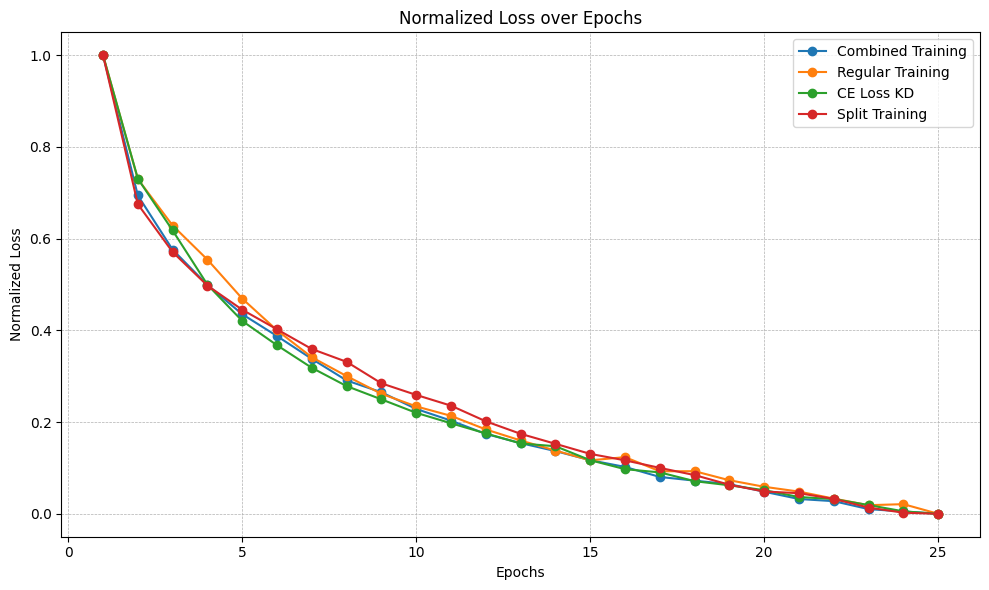

In [57]:



model_names = ['Combined Training', 'Regular Training', 'CE Loss KD', 'Split Training']

total_losses_norm = normalize_losses(total_losses)
plot_normalized_losses(total_losses_norm, model_names)


In [63]:
from helper import *

[76.23, 76.7, 73.79, 72.74]


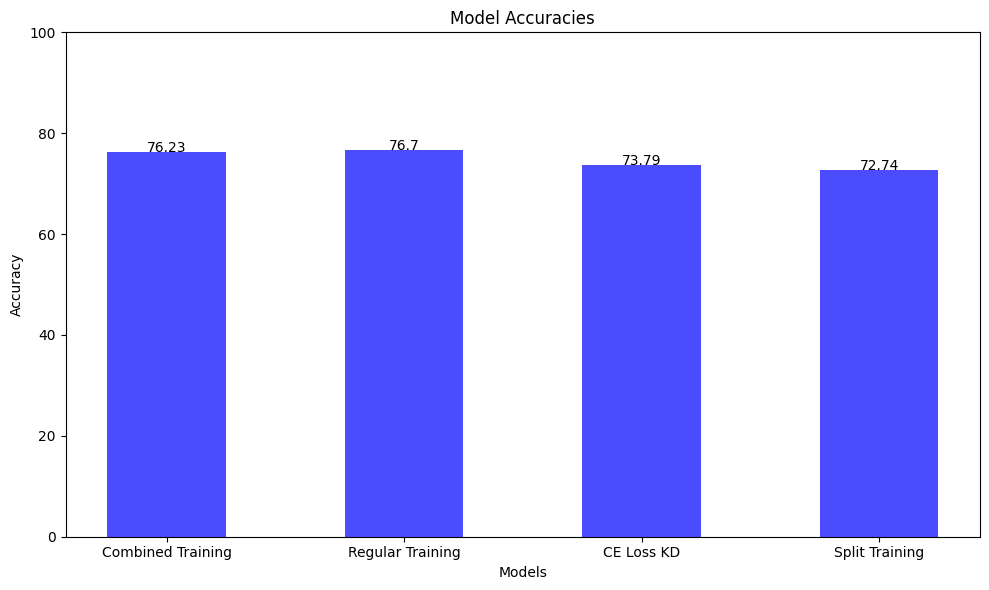

In [64]:
print(acc)
plot_model_accuracies(model_names, acc)

In [ ]:
student_test_first_stage = studentNN().to(device)
student_layer = student_test_first_stage.pool2
test_hook_s = Hook(student_layer)
test_hook_t = Hook(teacher_layer)
acc = test(student_test_first_stage, test_loader, device)
print(acc)
acc = test(teacher_resnet50, test_loader, device)
print(acc)
print(test_hook_t.output.shape)
regressor_test = ConvolutionalRegressor2().to(device)
x = regressor_test(test_hook_t.output)
print(x.shape)
print(test_hook_s.output.shape)


In [ ]:
student_test_first_stage = studentNN().to(device)
train_first_stage(train_loader, 
                  student_test_first_stage, 
                  teacher_resnet50, 
                  hint_loss, 
                  10, 
                  learning_rate=0.001, 
                  student_layer=student_layer_kd_combine, 
                  teacher_layer=teacher_layer)
test(student_test_first_stage, test_loader, device)

First stage training optimizes up to the hidden layer specified earlier, and uses the loss between teacher and student activations. Afterwards, we continue with the regular training routine

## RESNET18 Student

In [ ]:
from torchvision import models 


In [ ]:
learning_rate = 0.1
batch_size = 128
T = 3
soft_target_loss_weight = 0.6

In [ ]:
student = models.resnet18()
student.fc = nn.Linear(student.fc.in_features, 10)
student = student.to(device)
for param in student.parameters():
    param.requires_grad = True

In [ ]:
teacher = models.resnet50()
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
teacher.load_state_dict(torch.load('trained_model/teacher_finetuned_cifar10_v2.pth'))
teacher = teacher.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)